- title: HVAC Review Using Sidetable
- date: 2021-04-11 16:00
- tags: hvac, python, notebook, sidetable
- author: Christopher
- summary: Use Sidetable and Jupyter Notebook to do some analysis.
- category: Python
- Status: published
- comment_id: hvac-review-sidetable


## Problem Statement

Review the HVAC data and show how bad the refrigeration leak is.

## Description

I used a Rasperry Pi and some thermocouples to measure the inlet and
outlet of my HVAC system.
The temperature delta should be 18F when the AC kicks on.

## Data Sources

I have the data in a PostgreSQL database.
For the purposes of this post, I will provide the data in a CSV file.

## Overview

This post will go through and use sidetable to help with some basic
analysis.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import seaborn as sns
import sidetable

In [2]:
# Use to see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# See matplotlib/Seaborn in notebook
%matplotlib inline

sns.set( style = "white" ) 

## Load the Data

The data is located in my
[data repo](https://github.com/cetyler/github_data/hvac_review).
I would suggest that you download the data to your PC.

In [3]:
today = datetime.today()
project_folder = Path.cwd()
raw_file = (
    "https://raw.githubusercontent.com/cetyler/github_data/main/hvac_review/hvac_Apr-10-2021.csv"
)
df = pd.read_csv(raw_file)
df.head()

,timestamp,name,location,temperature,humidity
0,2020-11-05 23:46:40,Ambient,Basement,63.00,56.0
1,2020-08-24 20:13:20,Ambient,Basement,69.00,57.9
2,2020-08-24 20:13:20,Inlet,HVAC,74.64,NaN
3,2020-08-24 20:13:20,Outlet,HVAC,56.75,NaN
4,2020-08-24 20:13:20,Ambient,Basement,69.00,57.9


Probably don't need any of the basement data.
Will filter out basement data and also don't need humidity either.

In [4]:
mask = df["location"] != "Basement"
df = df[mask]

df = df[["timestamp", "name", "temperature"]]
df.head()
df.dtypes

,timestamp,name,temperature
2,2020-08-24 20:13:20,Inlet,74.64
3,2020-08-24 20:13:20,Outlet,56.75
5,2020-08-24 20:13:20,Inlet,74.53
6,2020-08-24 20:13:20,Outlet,56.98
8,2020-08-24 20:13:20,Inlet,74.53


timestamp       object
name            object
temperature    float64
dtype: object

The last bit is to create a temperature difference column and sort the data.

In [5]:
df.drop_duplicates(subset=["timestamp", "name"], inplace=True)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

df = df.sort_values(by="timestamp")

df["diff"] = df["temperature"].diff()
df["diff_abs"] = abs(df["temperature"].diff().round(0))
df.head()

,name,temperature,diff,diff_abs
timestamp,,,,
2020-08-22 23:46:40,Inlet,72.95,NaN,NaN
2020-08-22 23:46:40,Outlet,60.12,-12.83,13.0
2020-08-23 02:33:20,Inlet,72.39,12.27,12.0
2020-08-23 02:33:20,Outlet,61.59,-10.80,11.0
2020-08-23 05:20:00,Inlet,70.14,8.55,9.0


Notice that I created a column with the absolute difference and I rounded the
values.

## Initial Analysis

Let's see how using sidetable can help understand the data some more.

In [6]:
df.stb.freq(["diff_abs"]).head(10)

,diff_abs,count,percent,cumulative_count,cumulative_percent
0,11.0,150,12.145749,150,12.145749
1,12.0,106,8.582996,256,20.728745
2,10.0,99,8.016194,355,28.744939
3,14.0,97,7.854251,452,36.599190
4,15.0,87,7.044534,539,43.643725
5,13.0,86,6.963563,625,50.607287
6,16.0,74,5.991903,699,56.599190
7,17.0,60,4.858300,759,61.457490
8,1.0,34,2.753036,793,64.210526
9,18.0,32,2.591093,825,66.801619


This data is showing that the highest difference is 11F while 18F is pretty far
down.
However this could be due to how long it takes for my AC to get to the max
difference.

This may require a chart.

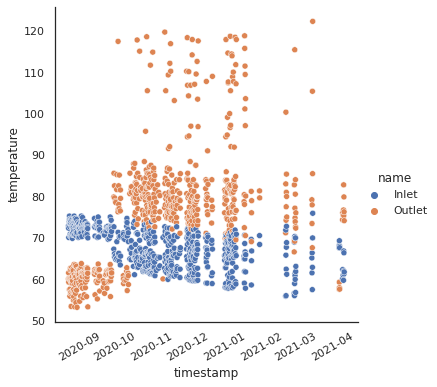

In [7]:
g = sns.relplot(data=df, x="timestamp", y="temperature", hue="name" ,kind="scatter")
g.set_xticklabels(rotation=30)

This shows that a good chunk of my data is when the heat was on.
Will filter the data to stop at the end of September.

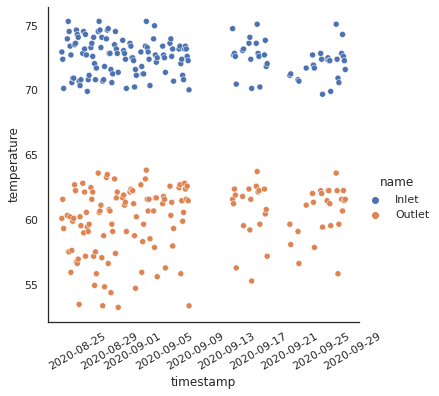

In [8]:
df_ac = df[df.index < datetime(2020, 9, 29, 0, 0)]
g = sns.relplot(data=df_ac, x="timestamp", y="temperature", hue="name" ,kind="scatter")
g.set_xticklabels(rotation=30)

Now let's look at temperature difference.
I will only look at the Outlet difference.
The way I calculated the difference by subtracting from the previous row,
Outlet (Inlet - Outlet) whereas the value for Inlet (Outlet - Inlet).

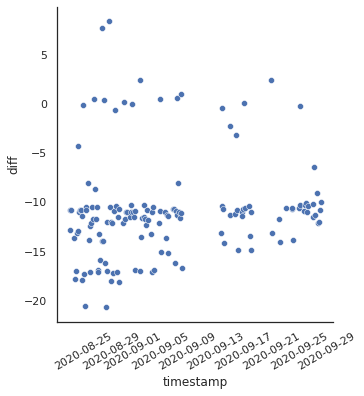

In [9]:
g = sns.relplot(data=df_ac[df_ac["name"] == "Outlet"], x="timestamp", y="diff", kind="scatter")
g.set_xticklabels(rotation=30)

This appears that the max difference was -20F from August but was trending
upward to -15F by the end of September.
This could be either be that September is a cooler month than August so the AC
doesn't run as long or most likely the refrigeration leak is bad enough that
the unit will need to be replaced.

## Conclusion

This post was to do an initial analysis of my HVAC.
Normally when I do initial analysis of something, I am not concerned with
presentation.
When I am at work, something like this is not even shared as I am just trying
to wrap my head around the issue.

For example, my HVAC data is only across 2 months for when the AC was in use.
Ideally it would be helpful to have more information like multiple years.
Also it may be useful to understand the ambient temperature and see if that
changes the max difference.

The secondary goal of this post was to try out
[sidetable](https://github.com/chris1610/sidetable) and to write a post using
Jupyter Notebook.